# Задача  
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.  
  
**Техпроцесс**  
Сталь обрабатывают в металлическом ковше. Расплавленную сталь заливают в ковш, добавляют сыпучие и проволочные добавки, подогревают до температуры примерно 1600°C графитовыми электродами, затем идет отбор пробы из ковша, так же в процессе производства может использоваться газ.  
Затем берут пробу и повторяют цикл несколько раз до достижения нужного результата.  
  
**Предоставленные данные:**  
data_arc.csv — данные об электродах;  
data_bulk.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time.csv — данные о подаче сыпучих материалов (время);  
data_gas.csv — данные о продувке сплава газом;  
data_temp.csv — результаты измерения температуры;  
data_wire.csv — данные о проволочных материалах (объём);  
data_wire_time.csv — данные о проволочных материалах (время).

## Загрузка и предобработка и анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### data_arc — данные об электродах

In [3]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Переведем дату в тип дата

In [5]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [6]:
data_arc['key'].nunique()

3214

Колонка "key" является номером загруженной партии  
Количество уникальных партий 3214

Переименуем столбцы

In [7]:
data_arc.set_axis(['key', 'start_heat', 'end_heat', 'act_power', 'react_power'], axis='columns', inplace=True)

<AxesSubplot:>

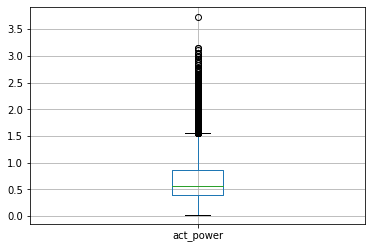

In [8]:
data_arc.boxplot('act_power')

<AxesSubplot:>

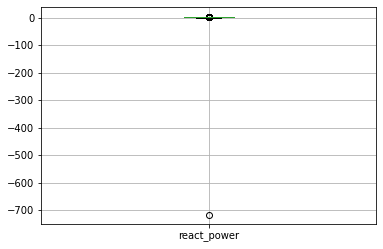

In [9]:
data_arc.boxplot('react_power')

Взглянем на эту партию

In [10]:
data_arc[data_arc['key'] == data_arc[data_arc['react_power'] < -100]['key'].values[0]]

,key,start_heat,end_heat,act_power,react_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Из законов физики знаем что реактивная мощность линейно зависима от активной, соответственно они должны сильно коррелировать

In [11]:
data_arc['act_power'].corr(data_arc['react_power'])

0.0544372433969374

А если без выброса?

In [12]:
data_arc['act_power'].corr(data_arc[data_arc['react_power'] > -700]['react_power'])

0.9631819131519804

Взглянем на корелляцию мощностей из верхних выбросов Активной мощности  
Определим границу верхнего "уса" ящика

In [13]:
upper_limit = data_arc['act_power'].quantile(0.75) + 1.5 * (data_arc['act_power'].quantile(0.75) - data_arc['act_power'].quantile(0.25))

In [14]:
data_arc.query('act_power > @upper_limit')['act_power'].corr(data_arc.query('act_power > @upper_limit')['react_power'])

0.8552827842539855

Корреляция на больших мощнастях меньше, но все равно достаточно сильная  
Вывод состоит в том что эти выбросы являются достаточно редкими, но все равно рабочими значениями, поэтому удалять мы их не будем

Воспользуемся медианным значением среди всех отношений активной и реактивной мощностями для исправления выброса

In [15]:
data_arc.loc[data_arc['react_power'] < -700, 'react_power'] = (data_arc['act_power'] / data_arc['react_power']).mean()

<AxesSubplot:>

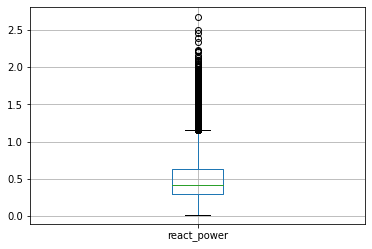

In [16]:
data_arc.boxplot('react_power')

### data_bulk - данные о подаче сыпучих материалов (объем)

In [17]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [18]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Приведем названия столбцов к нормальному виду

In [19]:
# Функция переименования колонок 
rename_col = lambda x: x.split()[0].lower() + '_' + x.split()[1] if len(x) > 3 else x

In [20]:
data_bulk.columns = data_bulk.columns.map(rename_col)

<AxesSubplot:>

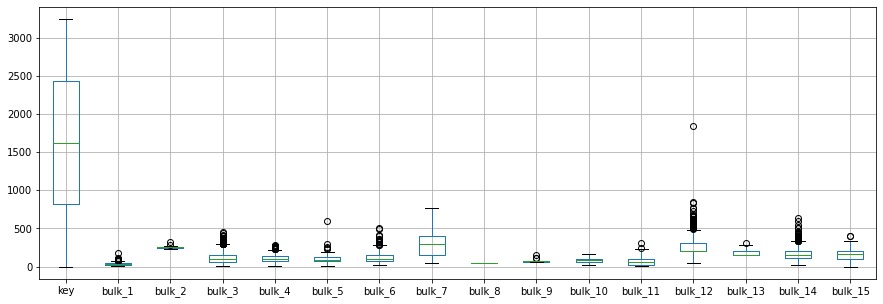

In [21]:
data_bulk.boxplot(figsize=(15,5))

Значения "NaN" являются не пропусками, а отсутствием добавки, следовательно заменим их на 0

In [22]:
data_bulk.fillna(0, inplace=True)

### data_bulk_time - данные о подаче сыпучих материалов (время)

In [23]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Используя функцию rename_col для переименования колонок

In [25]:
data_bulk_time.columns = data_bulk_time.columns.map(rename_col)

Приведем дату и время к стандартному формату

In [26]:
for i in data_bulk_time.columns[1:]:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S', errors='ignore')

### data_wire - данные о проволочных материалах (объём)

In [27]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Переименуем столбцы

In [29]:
data_wire.columns = data_wire.columns.map(rename_col)

<AxesSubplot:>

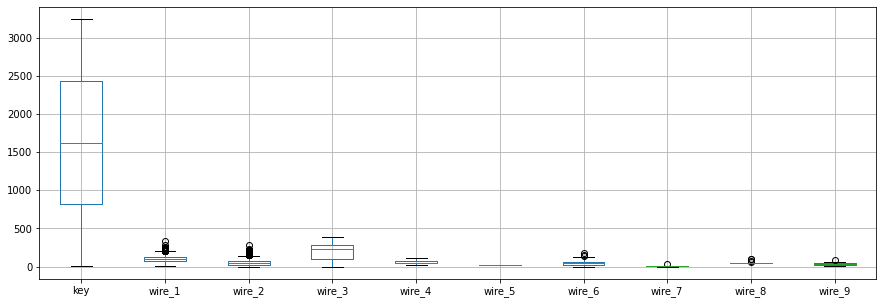

In [30]:
data_wire.boxplot(figsize=(15, 5))

Значения "NaN" являются не пропусками, а отсутствием добавки, следовательно заменим их на 0

In [31]:
data_wire.fillna(0, inplace=True)

### data_bulk_time - данные о подаче сыпучих материалов (время)

In [32]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Переименуем столбцы

In [34]:
data_wire_time.columns = data_wire_time.columns.map(rename_col)

Переведем в дату и время

In [35]:
for i in data_wire_time.columns[1:]:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i], format='%Y-%m-%d %H:%M:%S', errors='ignore')

### data_gas - данные о продувке сплава газом

In [36]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Переименуем столбец

In [37]:
data_gas.columns = ['key', 'gas']

<AxesSubplot:>

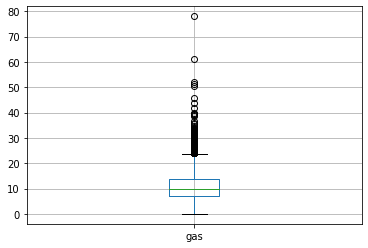

In [38]:
data_gas.boxplot('gas')

In [39]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Количество партий "key" в таблице с газом не совпадает с количеством партий в таблице с мощностью  
Посмотрим на их разницу

In [40]:
data_gas['key'].nunique() - data_arc['key'].nunique()

25

In [41]:
gas = data_gas['key'].unique()
arc = data_arc['key'].unique()

Посмотрим на партии, которые есть в данных с мощностью, но отсутствуют в данных с газом

In [42]:
print([x for x in data_arc['key'].unique() if x not in gas])

[193, 259]


И обратное, партии которые есть в данных с газом и отсутствуют в мощности

In [43]:
print([x for x in gas if x not in arc])

[41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


Исследуем эти 27 строк более детально

In [44]:
ls = [x for x in gas if x not in arc] # список партий на которые есть газ, но отсутствует мощность

In [45]:
data_gas.query('key in @ls')['gas'].describe()

count    27.000000
mean      0.997573
std       1.311086
min       0.263029
25%       0.378540
50%       0.783096
75%       1.032258
max       7.232359
Name: gas, dtype: float64

<AxesSubplot:>

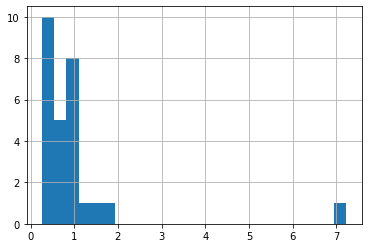

In [46]:
data_gas.query('key in @ls')['gas'].hist(bins=25)

In [47]:
data_gas['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

<AxesSubplot:>

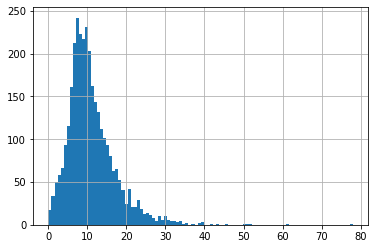

In [48]:
data_gas['gas'].hist(bins=100)

Выборка из 27 значений не случайна, т.к. даже 3-й квантиль(1,03) в ней меньше 1-го квантиля(7,04) всех данных по газу  
Возможно это были подготовительные технологические запуски установки

Необходимо учесть несовпадения в случае соединения таблиц

### data_temp - результаты измерения температуры

In [49]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [50]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Колонка с температурой является целевой метрикой, в ней присутствует 2901 пропуск - однозначно на удаление  
Переименуем в правильный формат названия колонок

In [51]:
data_temp.set_axis(['key', 'measurement_time', 'temp'], axis=1, inplace=True)

In [52]:
data_temp.head()

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<AxesSubplot:>

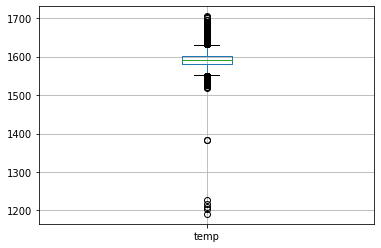

In [53]:
data_temp.boxplot('temp')

Температура в ковше не должна падать ниже 1450°C, иначе сплав остынет, поэтому значения ниже являются выбросами

In [54]:
data_temp.query('temp < 1450')

,key,measurement_time,temp
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [55]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'], format='%Y-%m-%d %H:%M:%S')

In [56]:
keys = [867, 1214, 1619, 1818, 2052, 2561]

Ни в одном из случаев это не является финальным замером, значит партии удалять не будем, за исключением партии с менее 2 замерами и партии с пропусками

In [57]:
data_measure_count = data_temp.groupby(by='key').count().reset_index()

In [58]:
data_group_key = data_temp.groupby(by='key').agg(count_temp=('temp', 'count'), first_temp=('temp', 'first'), last_temp=('temp', 'last')).reset_index()

In [59]:
data_group_key.head()

,key,count_temp,first_temp,last_temp
0,1,5,1571.0,1613.0
1,2,6,1581.0,1602.0
2,3,5,1596.0,1599.0
3,4,3,1601.0,1625.0
4,5,2,1576.0,1602.0


Найдем номера партий, которые удовлетворяют условиям:  
 - первая и последняя температура не являются выбросами;  
 - первая и последняя температура не являются NaN;  
 - соличество замеров в партии боле 1 раза

In [60]:
good_keys = data_group_key[(~data_group_key['first_temp'].isna()) & (~data_group_key['last_temp'].isna()) & 
                         (data_group_key['first_temp'] > 1400) & (data_group_key['last_temp'] > 1400) & 
                         (data_group_key['count_temp'] > 1)]['key'].unique()

In [61]:
len(good_keys)

2471

In [62]:
data_temp = data_temp.query('key in @good_keys')

## Создание таблицы

Определим признаки, которые нам нужны:  
 - из активной и реактивной мощностей сделаем полную по физической формуле $S=\sqrt[2]{P^2+Q^2}$, так же найдем продолжительность нагрева по времени и среднее этих значений на количество включений для каждой партии;  
 - из данных по сыпучим и проволочным добавкам возьмем только их объем, данные по времени добавления не понадобятся;  
 - партии которые есть в данных с газом понадобятся только те, которые есть в таблице с целевым признаком;  
 - из таблицы с целевым признаком нужны только первый замер, последний замер и их количество

Узнаем время каждого нагрева в секундах

In [63]:
data_arc['time_heat'] = (data_arc['end_heat'] - data_arc['start_heat']).dt.seconds

In [64]:
data_arc['time_heat'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_heat, dtype: float64

Отрицательных значений нет

Вычислим полную мощность 

In [65]:
data_arc['power'] = (data_arc['act_power'] ** 2 + data_arc['react_power'] ** 2) ** 0.5

Посчитаем сколько времени прошло между каждым нагревом внутри каждой партии

In [66]:
data_arc['time_no_heat'] = pd.Series((data_arc.groupby('key')['start_heat'].shift(-1) - data_arc['end_heat']).dt.seconds.fillna(0))

In [67]:
data_arc.head()

,key,start_heat,end_heat,act_power,react_power,time_heat,power,time_no_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,86.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,71.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,218.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,110.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,0.0


In [68]:
data_arc_group = data_arc.groupby('key').agg(heat_count=('key', 'count'), 
                                             mean_time=('time_heat', 'mean'), power=('power', 'sum'), 
                                             time_no_heat=('time_no_heat', 'sum')).reset_index()

In [69]:
data_arc_group.head()

,key,heat_count,mean_time,power,time_no_heat
0,1,5,219.60,5.826395,485.0
1,2,4,202.75,3.649216,333.0
2,3,5,131.00,2.989534,870.0
3,4,4,185.25,3.814962,352.0
4,5,4,217.25,4.035758,493.0


Сформируем таблицу с целевым признаком  

In [70]:
data_temp_group = data_temp.groupby('key').agg(first_temp=('temp', 'first'), last_temp=('temp', 'last'),
                                               measure_count=('measurement_time', 'count')).reset_index()

In [71]:
data_temp_group.head()

,key,first_temp,last_temp,measure_count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2


Соединим подготовленные таблицы в одну

In [72]:
data_final = data_temp_group.merge(data_arc_group, 
                                   on='key').merge(data_gas, on='key').merge(data_bulk, 
                                   on='key',how='left').merge(data_wire, on='key', how='left')

In [73]:
data_final.fillna(0, inplace=True)

Удалим уникальные номера партий

In [74]:
del data_final['key']

In [75]:
data_final.head()

,first_temp,last_temp,measure_count,heat_count,mean_time,power,time_no_heat,gas,bulk_1,bulk_2,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1571.0,1613.0,5,5,219.60,5.826395,485.0,29.749986,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,6,4,202.75,3.649216,333.0,12.555561,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,5,5,131.00,2.989534,870.0,28.554793,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,3,4,185.25,3.814962,352.0,18.841219,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,2,4,217.25,4.035758,493.0,5.413692,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2468
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   first_temp     2469 non-null   float64
 1   last_temp      2469 non-null   float64
 2   measure_count  2469 non-null   int64  
 3   heat_count     2469 non-null   int64  
 4   mean_time      2469 non-null   float64
 5   power          2469 non-null   float64
 6   time_no_heat   2469 non-null   float64
 7   gas            2469 non-null   float64
 8   bulk_1         2469 non-null   float64
 9   bulk_2         2469 non-null   float64
 10  bulk_3         2469 non-null   float64
 11  bulk_4         2469 non-null   float64
 12  bulk_5         2469 non-null   float64
 13  bulk_6         2469 non-null   float64
 14  bulk_7         2469 non-null   float64
 15  bulk_8         2469 non-null   float64
 16  bulk_9         2469 non-null   float64
 17  bulk_10        2469 non-null   float64
 18  bulk_11 

Посмотрим на тепловую карту корреляций в данных

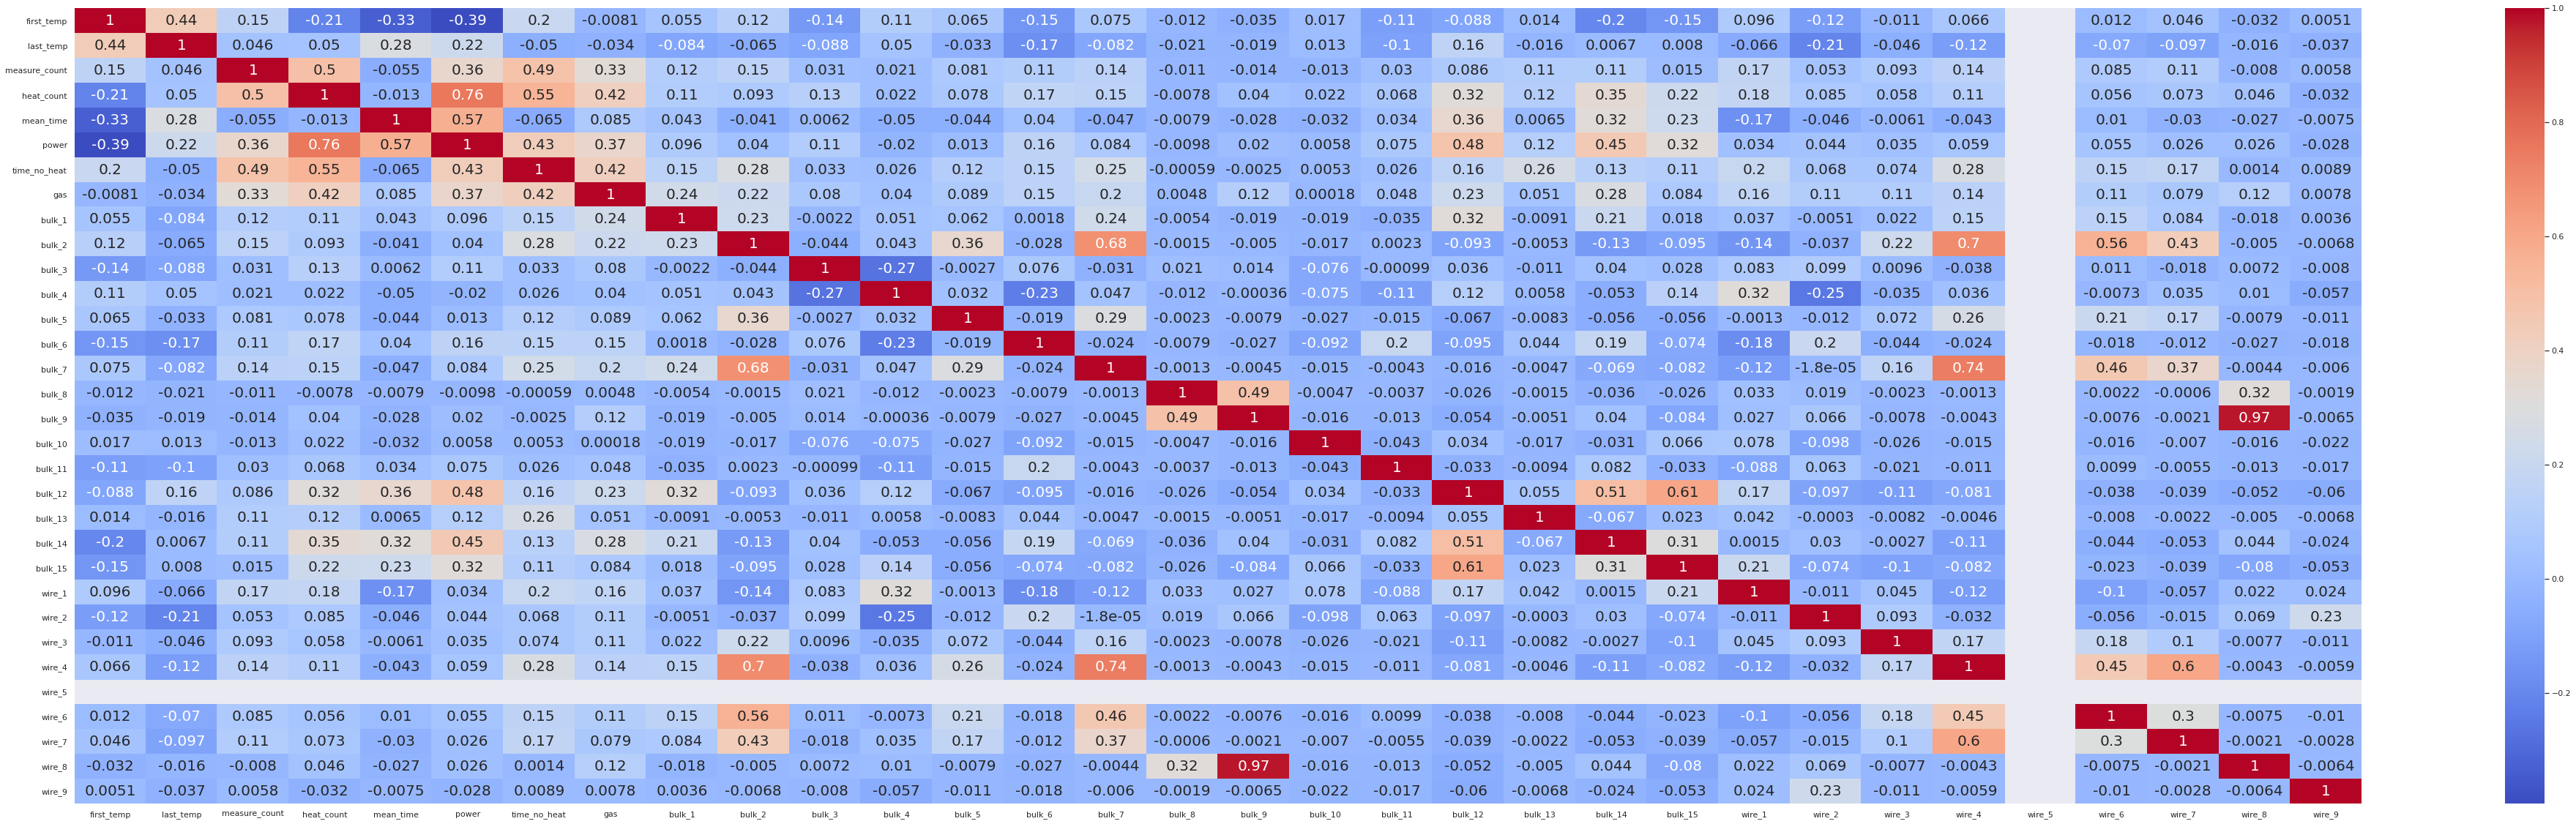

In [79]:
sns.heatmap(data_final.corr(), cmap='coolwarm', annot=True, annot_kws={"fontsize":20})
sns.set(rc={'figure.figsize':(70, 20)})
plt.show()

Признак wire_5 не использовался ни разу  
Признаки bulk_9 и wire_8 сильно друг с другом коррелируют  
В остальных случаях имеется не такая сильная корреляция

In [80]:
data_final['bulk_9'].corr(data_final['wire_8'])

0.9749758004144076

Удалим пустой признак wire_5 и сильно коррелирующий wire_8

In [81]:
del data_final['wire_5']
del data_final['wire_8']

In [82]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2469 entries, 0 to 2468
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   first_temp     2469 non-null   float64
 1   last_temp      2469 non-null   float64
 2   measure_count  2469 non-null   int64  
 3   heat_count     2469 non-null   int64  
 4   mean_time      2469 non-null   float64
 5   power          2469 non-null   float64
 6   time_no_heat   2469 non-null   float64
 7   gas            2469 non-null   float64
 8   bulk_1         2469 non-null   float64
 9   bulk_2         2469 non-null   float64
 10  bulk_3         2469 non-null   float64
 11  bulk_4         2469 non-null   float64
 12  bulk_5         2469 non-null   float64
 13  bulk_6         2469 non-null   float64
 14  bulk_7         2469 non-null   float64
 15  bulk_8         2469 non-null   float64
 16  bulk_9         2469 non-null   float64
 17  bulk_10        2469 non-null   float64
 18  bulk_11 

## Обучение и валидация моделей

In [83]:
features = data_final.drop('last_temp', axis=1)
target = data_final['last_temp']

Функция с валидацией

In [84]:
def get_scores(model, X, y, show=True, simple_response=True) -> float:
    """Displays cross-validation results if 'show'=True and returns the maximum test MAE"""
    cv_result = cross_validate(
        model, X, y, scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
    cv_result['test_score'] *= -1
    cv_result['train_score'] *= -1
    cv_result = pd.DataFrame(cv_result)
    if show:
        display(cv_result.describe())
    elif simple_response:
        return cv_result.test_score.mean()
    else:
        return cv_result['test_score']

### Линейная регрессия

In [85]:
linear = LinearRegression()

In [86]:
get_scores(linear, features, target)

,fit_time,score_time,test_score,train_score
count,5.000000,5.000000,5.000000,5.000000
mean,0.066009,0.055877,6.980638,6.737039
std,0.048998,0.041699,0.410612,0.108902
min,0.005266,0.011366,6.431007,6.632399
25%,0.020310,0.018673,6.720645,6.653959
50%,0.096081,0.052989,7.051584,6.743902
75%,0.102690,0.097025,7.234087,6.746272
max,0.105697,0.099332,7.465867,6.908661


In [87]:
get_scores(linear, features, target, show=False)

6.980637939429963

### Случайный лес

С помощью рандомизированного поиска параметров найдем относительно оптимальные параметры

In [88]:
rf = RandomForestRegressor()

In [89]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 25)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 32, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 63, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 53, num = 10)]
param_dist = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(rf, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error',
                        random_state=0)

In [90]:
rs.fit(features, target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 12, 14, 16,
                                                      18, 20, 23, 25, 27, 29,
                                                      32],
                                        'min_samples_leaf': [2, 7, 13, 19, 24,
                                                             30, 36, 41, 47,
                                                             53],
                                        'min_samples_split': [2, 8, 15, 22, 29,
                                                              35, 42, 49, 56,
                                                              63],
                                        'n_estimators': [100, 137, 175, 212,
                                                         250, 287, 325, 362,
                                                         400, 437, 475, 512,
  

In [91]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
rs_df.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,4.383114,0.109083,0.052866,0.001555,325,2,2,18,"{'n_estimators': 325, 'min_samples_split': 2, ...",-6.530629,-6.228805,-5.512549,-6.575251,-6.303268,-6.230100,0.382016,1
96,8.441473,0.196611,0.098571,0.003614,700,8,2,14,"{'n_estimators': 700, 'min_samples_split': 8, ...",-6.610731,-6.293547,-5.486251,-6.545417,-6.299850,-6.247159,0.401261,2
35,7.776838,0.214715,0.090473,0.001662,700,22,2,16,"{'n_estimators': 700, 'min_samples_split': 22,...",-6.722389,-6.356687,-5.614398,-6.683977,-6.431837,-6.361858,0.399340,3
84,7.347874,0.121988,0.112170,0.034918,775,22,7,12,"{'n_estimators': 775, 'min_samples_split': 22,...",-6.860496,-6.438275,-5.667487,-6.794966,-6.415669,-6.435378,0.424284,4
41,3.651483,0.105544,0.046058,0.001167,362,22,7,23,"{'n_estimators': 362, 'min_samples_split': 22,...",-6.826240,-6.467324,-5.685436,-6.791540,-6.429154,-6.439939,0.410607,5
63,1.708098,0.021559,0.022373,0.001380,175,35,2,14,"{'n_estimators': 175, 'min_samples_split': 35,...",-6.894925,-6.475034,-5.778362,-6.817683,-6.507907,-6.494782,0.394512,6
88,1.446833,0.047457,0.020278,0.001297,137,35,2,20,"{'n_estimators': 137, 'min_samples_split': 35,...",-6.919315,-6.479958,-5.789009,-6.846270,-6.446894,-6.496289,0.401096,7
73,6.817288,0.194279,0.085344,0.001808,737,35,7,23,"{'n_estimators': 737, 'min_samples_split': 35,...",-7.030553,-6.518707,-5.776389,-6.893339,-6.544858,-6.552769,0.435489,8
2,1.864423,0.048216,0.025699,0.002814,212,42,7,27,"{'n_estimators': 212, 'min_samples_split': 42,...",-7.143423,-6.574272,-5.804904,-6.965236,-6.608048,-6.619177,0.460385,9
49,8.089109,0.211676,0.105933,0.004388,887,15,13,18,"{'n_estimators': 887, 'min_samples_split': 15,...",-7.039608,-6.651394,-5.801741,-6.911154,-6.706728,-6.622125,0.433330,10


In [92]:
rs_df['mean_test_score'] = rs_df['mean_test_score'] * -1

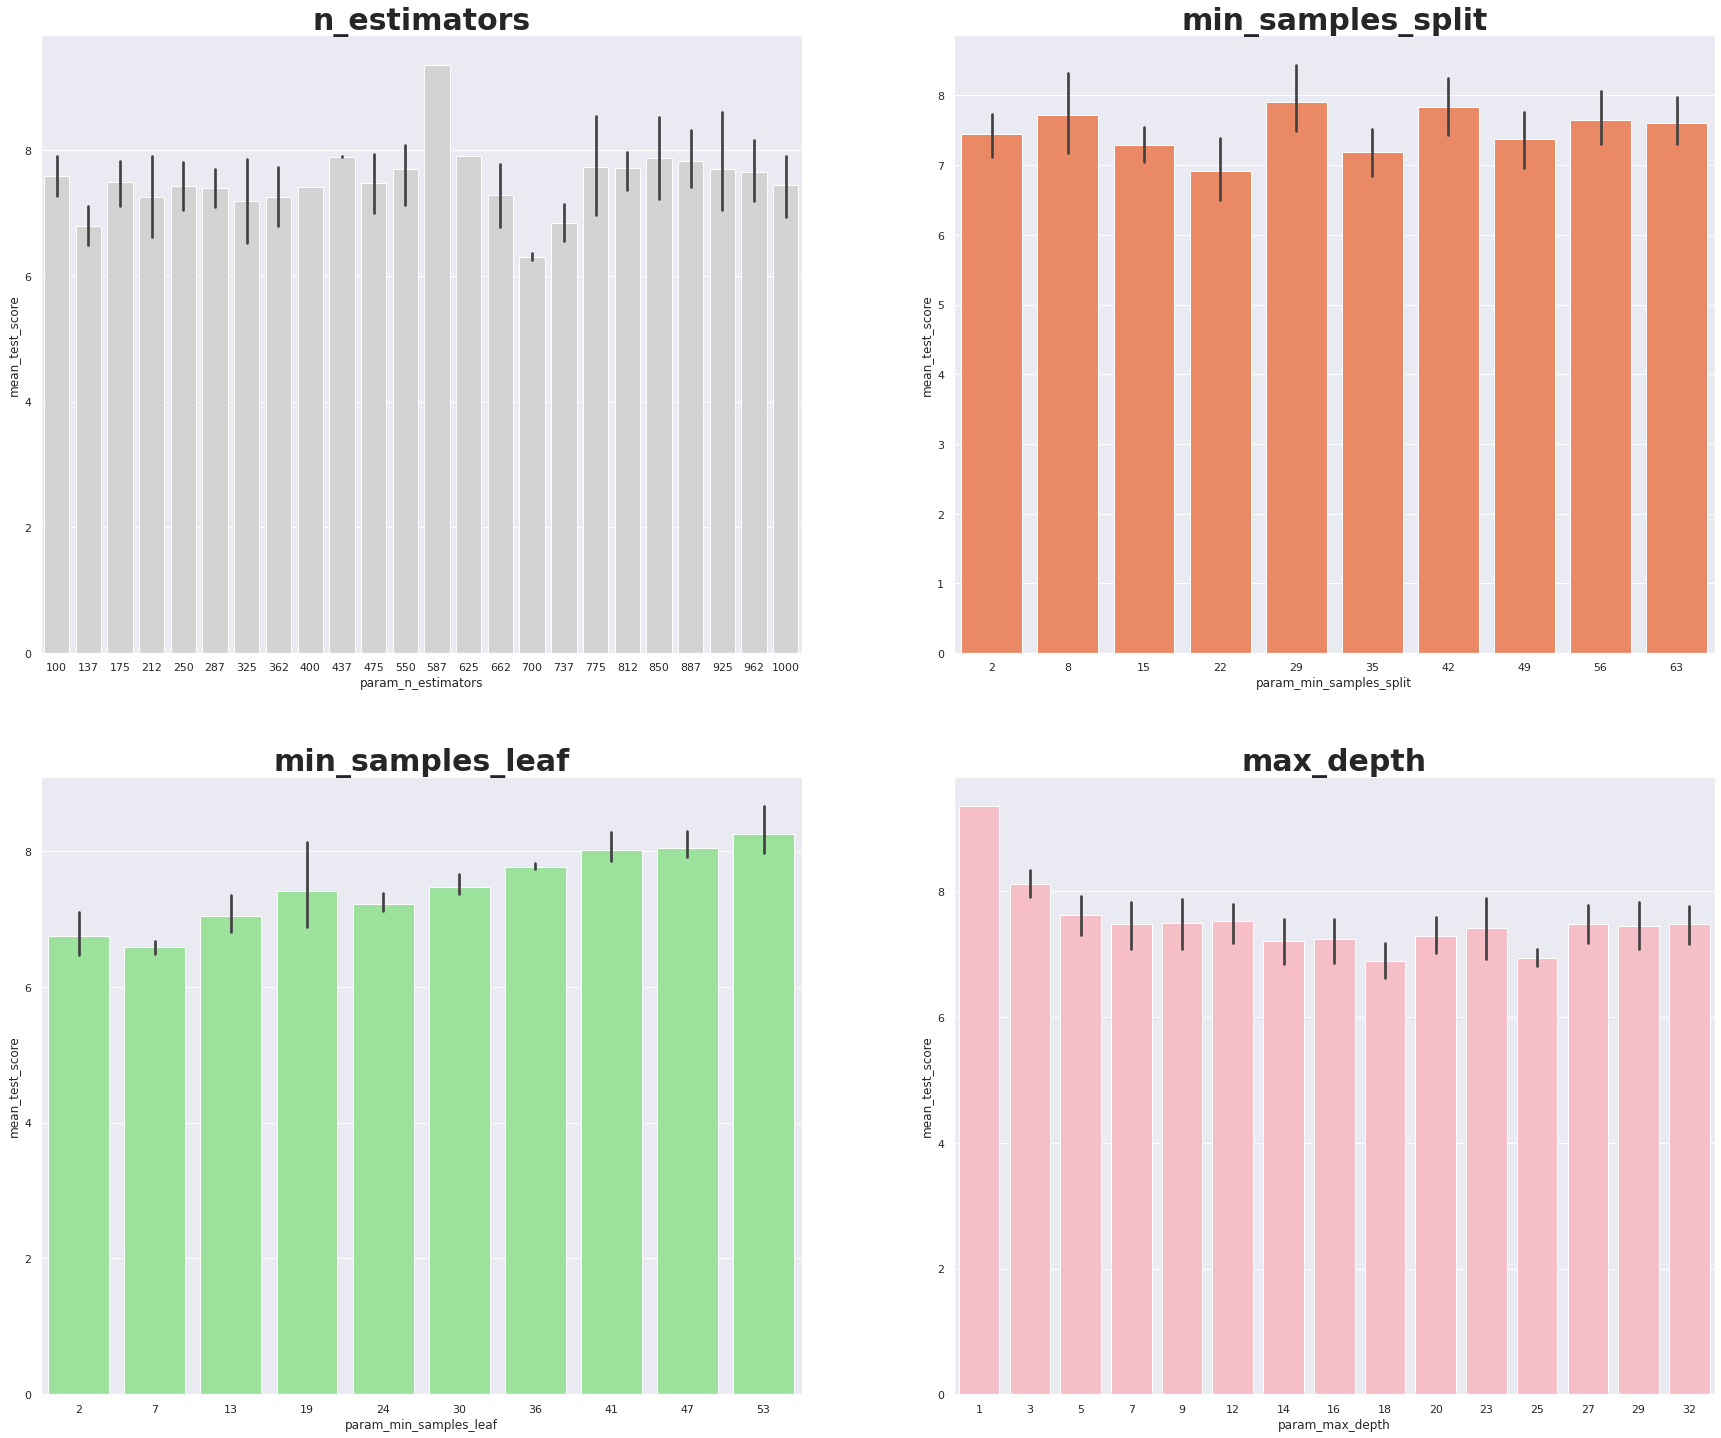

In [93]:
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim()
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim()
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[1,0], color='lightgreen')
axs[1,0].set_ylim()
axs[1,0].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim()
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
plt.show()

Лучшие метрики достигаются при параметрах  
 - **n_estimators** 700  
 - **min_samples_split** 22 и 35  
 - **min_samples_leaf** минимально 
 - **max_depth** 18  
Обучим случайный лес на этих параметрах и близких к ним

In [94]:
rf = RandomForestRegressor()
n_estimators = [int(x) for x in range(650, 776, 25)]
max_depth = [int(x) for x in range(18, 43, 8)]
min_samples_split = [int(x) for x in range(2, 23, 10)]
param_dist = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
rs = GridSearchCV(rf, 
                        param_dist, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error')

In [95]:
rs.fit(features, target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [18, 26, 34, 42],
                         'min_samples_split': [2, 12, 22],
                         'n_estimators': [650, 675, 700, 725, 750, 775]},
             scoring='neg_mean_absolute_error', verbose=1)

In [96]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
rs_df['mean_test_score'] = rs_df['mean_test_score'] * -1
rs_df.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,9.351026,0.193214,0.115545,0.006423,34,2,650,"{'max_depth': 34, 'min_samples_split': 2, 'n_e...",-6.540800,-6.250131,-5.504296,-6.561011,-6.333102,6.237868,0.385626,1
19,10.352026,0.169244,0.122738,0.003288,26,2,675,"{'max_depth': 26, 'min_samples_split': 2, 'n_e...",-6.587924,-6.235542,-5.487288,-6.563446,-6.317195,6.238279,0.399551,2
3,10.636036,0.130665,0.126917,0.001943,18,2,725,"{'max_depth': 18, 'min_samples_split': 2, 'n_e...",-6.535698,-6.248076,-5.478636,-6.567993,-6.371547,6.240390,0.398010,3
23,11.730865,0.240254,0.145766,0.007032,26,2,775,"{'max_depth': 26, 'min_samples_split': 2, 'n_e...",-6.529888,-6.219946,-5.508033,-6.587467,-6.363077,6.241682,0.388865,4
22,11.487912,0.231057,0.134933,0.003737,26,2,750,"{'max_depth': 26, 'min_samples_split': 2, 'n_e...",-6.535438,-6.243513,-5.494257,-6.584959,-6.362922,6.244218,0.394321,5
57,10.504468,0.220949,0.128824,0.005052,42,2,725,"{'max_depth': 42, 'min_samples_split': 2, 'n_e...",-6.530920,-6.245124,-5.511733,-6.575602,-6.359715,6.244619,0.385198,6
54,9.457601,0.184024,0.113576,0.001755,42,2,650,"{'max_depth': 42, 'min_samples_split': 2, 'n_e...",-6.520125,-6.273485,-5.497073,-6.559495,-6.383523,6.246740,0.388325,7
59,11.242003,0.260069,0.134646,0.003871,42,2,775,"{'max_depth': 42, 'min_samples_split': 2, 'n_e...",-6.553188,-6.249672,-5.516952,-6.564446,-6.356064,6.248064,0.384549,8
2,10.274492,0.128115,0.122859,0.003133,18,2,700,"{'max_depth': 18, 'min_samples_split': 2, 'n_e...",-6.560386,-6.242951,-5.510879,-6.562568,-6.363949,6.248147,0.388164,9
4,10.991138,0.199684,0.132606,0.003966,18,2,750,"{'max_depth': 18, 'min_samples_split': 2, 'n_e...",-6.542549,-6.250454,-5.503254,-6.593710,-6.352492,6.248492,0.392898,10


In [97]:
rs.best_params_

{'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 650}

In [98]:
forest = RandomForestRegressor(max_depth= 42, min_samples_split=2, n_estimators=725)
get_scores(forest, features, target, show=False)

6.245238108048485

<AxesSubplot:xlabel='importances', ylabel='features'>

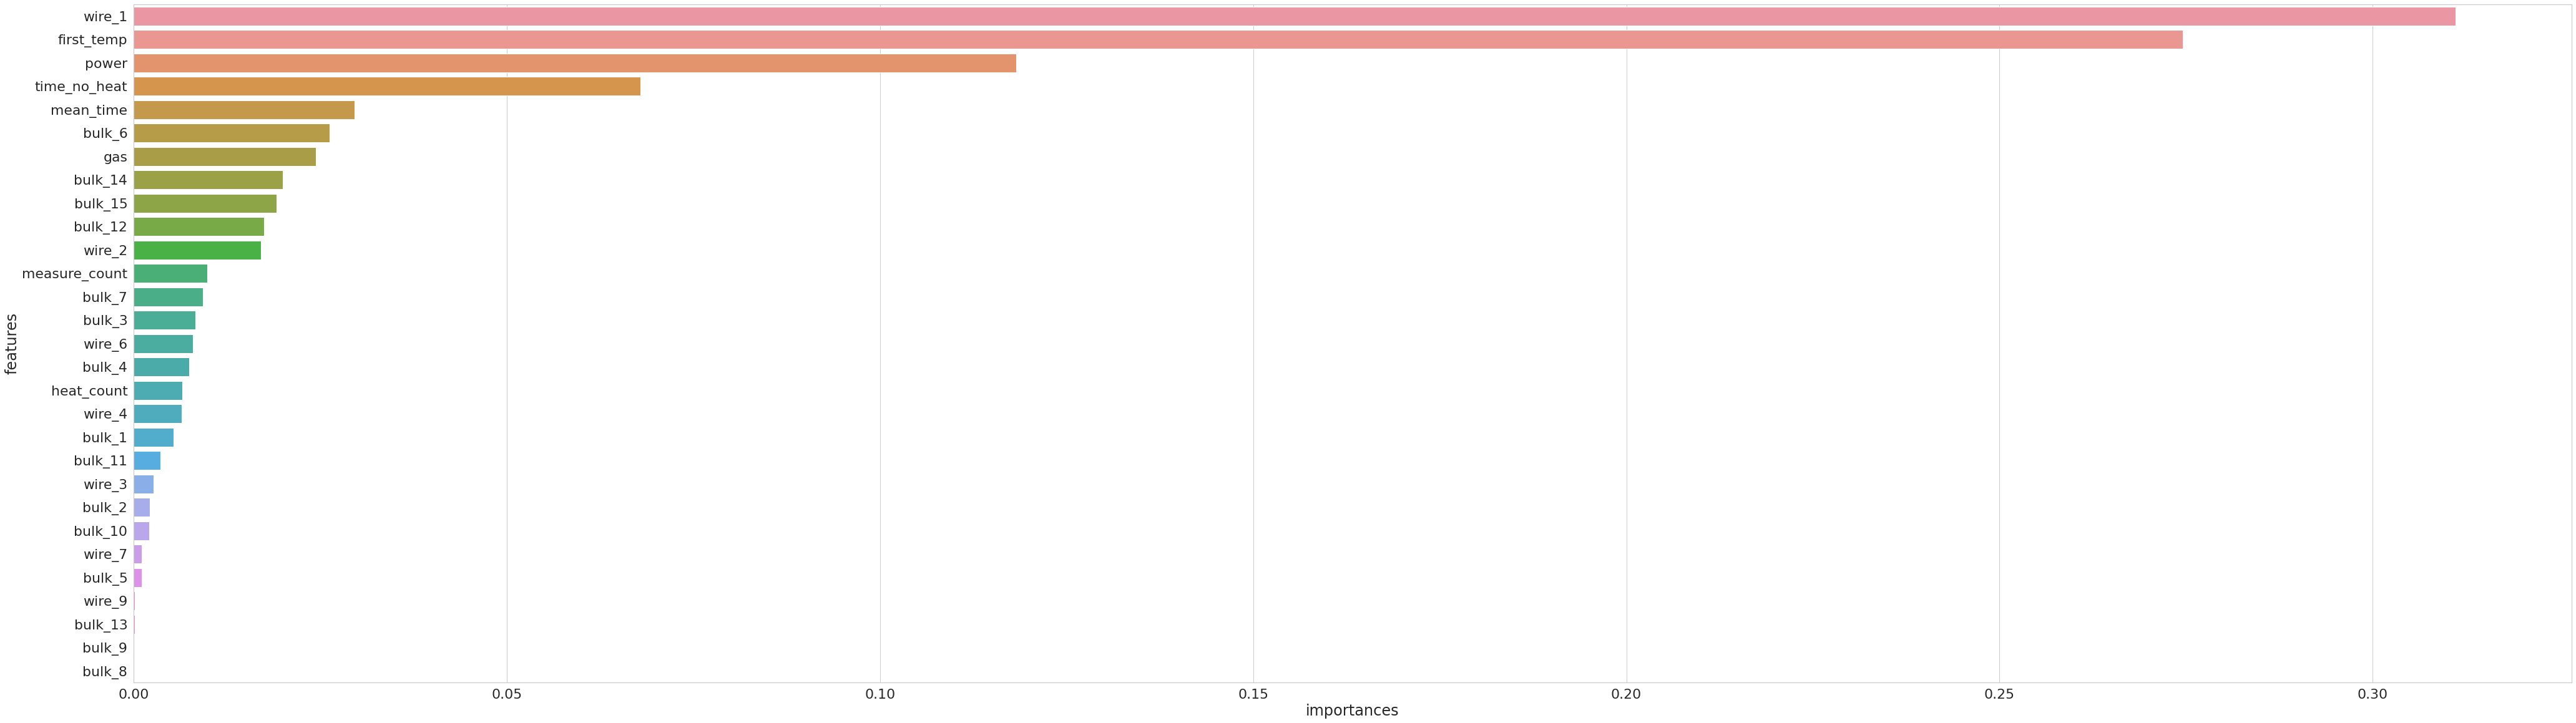

In [99]:
forest.fit(features, target)
importance = forest.feature_importances_
importances = pd.DataFrame({'features': features.columns, 'importances': importance})
importances = importances.sort_values('importances', ascending=False)
sns.barplot(x='importances', y='features', data=importances)

### XGBoost

Подберем примерный диапазон параметров случайным набором из сетки, числом в 200 итераций

In [100]:
xgb = XGBRegressor(booster='gbtree')

params = {'learning_rate': [0.05, 0.1, 0.3],
          'min_split_loss': [0, 0.5, 2, 10],
          'max_depth': [6, 7, 9, 10],
          'min_child_weight': [1, 3, 8, 12, 15],
          'subsample': [0.5, 0.7, 1],
          'colsample_bytree': [0.25, 0.5, 0.75, 1],
          'colsample_bylevel': [0.25, 0.5, 0.75, 1],
          'colsample_bynode': [0.25, 0.5, 0.75, 1],
          'tree_method': ['exact', 'hist'],
          }

In [101]:
xgb_gscv = RandomizedSearchCV(xgb, 
                        params, 
                        n_iter = 200, 
                        cv = 5, 
                        verbose = 1, 
                        scoring='neg_mean_absolute_error',
                        random_state=0)

In [102]:
xgb_gscv.fit(features, target)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constrai...
                   param_distributions={'colsample_bylevel': [0.25, 0.5, 0.75,
                                                              1],
                                        'colsa

Создадим таблицу с параметрами и отсортируем по среднему "MAE" 

In [103]:
xgb_gscv_df = pd.DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')
xgb_gscv_df['mean_test_score'] = xgb_gscv_df['mean_test_score'] * -1
xgb_gscv_df.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree_method,param_subsample,param_min_split_loss,param_min_child_weight,param_max_depth,param_learning_rate,...,param_colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
177,3.322507,0.082120,0.018554,0.025300,hist,0.7,2,8,9,0.1,...,1,"{'tree_method': 'hist', 'subsample': 0.7, 'min...",-6.113710,-5.817794,-5.286653,-5.860170,-5.879570,5.791579,0.272710,1
136,3.584251,0.323203,0.018133,0.025550,hist,1,0.5,15,10,0.1,...,0.75,"{'tree_method': 'hist', 'subsample': 1, 'min_s...",-6.167248,-5.863705,-5.306458,-5.834236,-6.049332,5.844196,0.295325,2
110,3.692561,0.237721,0.005800,0.000273,exact,0.7,2,1,9,0.1,...,0.75,"{'tree_method': 'exact', 'subsample': 0.7, 'mi...",-6.235037,-5.901649,-5.391206,-5.867622,-5.846740,5.848451,0.268969,3
92,3.615993,0.540876,0.006272,0.001253,exact,0.7,10,15,9,0.1,...,0.75,"{'tree_method': 'exact', 'subsample': 0.7, 'mi...",-6.371898,-5.853893,-5.343225,-5.813283,-5.978627,5.872185,0.330044,4
42,3.037977,0.085117,0.005503,0.000184,exact,0.7,10,12,7,0.1,...,1,"{'tree_method': 'exact', 'subsample': 0.7, 'mi...",-6.507203,-6.093970,-5.402010,-5.696058,-5.812335,5.902315,0.375117,5
75,2.965990,0.164645,0.018547,0.026051,exact,0.5,2,8,7,0.1,...,1,"{'tree_method': 'exact', 'subsample': 0.5, 'mi...",-6.375896,-5.919565,-5.460098,-5.898721,-5.960203,5.922897,0.290303,6
151,3.131060,0.082716,0.005520,0.000359,hist,0.5,0,12,9,0.1,...,0.75,"{'tree_method': 'hist', 'subsample': 0.5, 'min...",-6.301298,-6.000527,-5.342698,-5.875845,-6.105078,5.925089,0.322870,7
125,3.173781,0.173466,0.006616,0.002096,exact,0.7,0.5,15,7,0.1,...,1,"{'tree_method': 'exact', 'subsample': 0.7, 'mi...",-6.322504,-6.037603,-5.355092,-5.925990,-5.989453,5.926128,0.316112,8
86,5.063030,0.442327,0.011756,0.012465,hist,0.5,0,1,10,0.1,...,1,"{'tree_method': 'hist', 'subsample': 0.5, 'min...",-6.177008,-6.061471,-5.379255,-6.000984,-6.027381,5.929220,0.281474,9
11,3.192763,0.305501,0.005860,0.000727,exact,0.7,0.5,3,7,0.1,...,0.5,"{'tree_method': 'exact', 'subsample': 0.7, 'mi...",-6.116823,-6.132109,-5.367495,-6.014730,-6.022649,5.930761,0.285630,10


Визуализируем гиперпараметры моделей

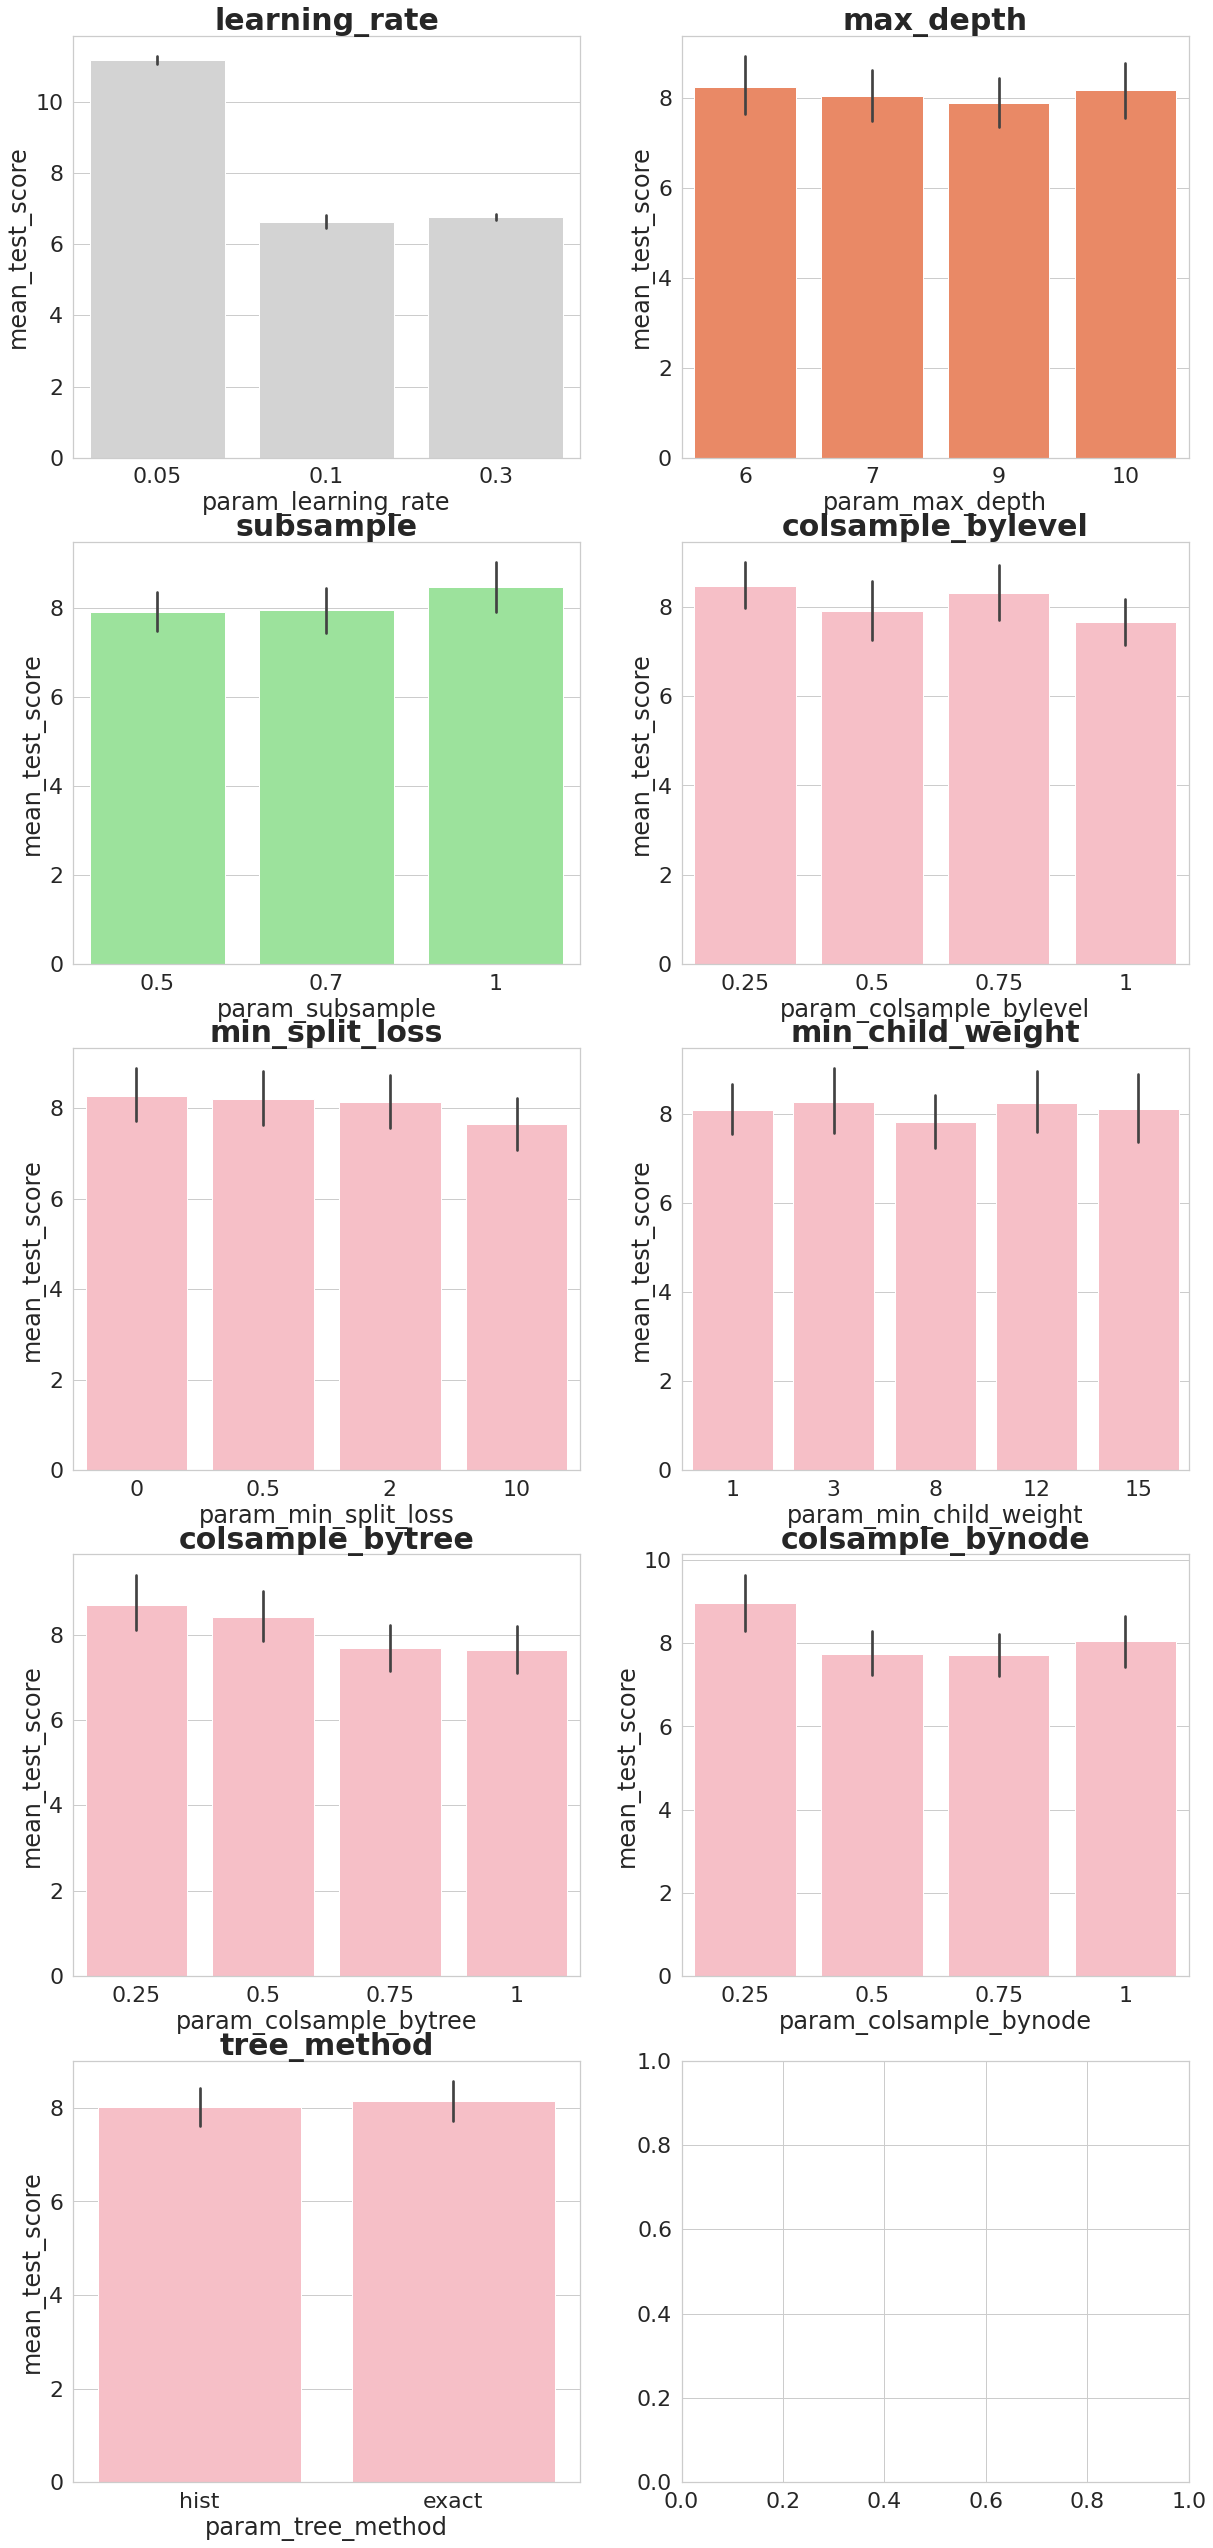

In [104]:
fig, axs = plt.subplots(ncols=2, nrows=5)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(20,45)
sns.barplot(x='param_learning_rate', y='mean_test_score', data=xgb_gscv_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim()
axs[0,0].set_title(label = 'learning_rate', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=xgb_gscv_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim()
axs[0,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_subsample', y='mean_test_score', data=xgb_gscv_df, ax=axs[1,0], color='lightgreen')
axs[1,0].set_ylim()
axs[1,0].set_title(label = 'subsample', size=30, weight='bold')
sns.barplot(x='param_colsample_bylevel', y='mean_test_score', data=xgb_gscv_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim()
axs[1,1].set_title(label = 'colsample_bylevel', size=30, weight='bold')
sns.barplot(x='param_min_split_loss', y='mean_test_score', data=xgb_gscv_df, ax=axs[2,0], color='lightpink')
axs[2,0].set_ylim()
axs[2,0].set_title(label = 'min_split_loss', size=30, weight='bold')
sns.barplot(x='param_min_child_weight', y='mean_test_score', data=xgb_gscv_df, ax=axs[2,1], color='lightpink')
axs[2,1].set_ylim()
axs[2,1].set_title(label = 'min_child_weight', size=30, weight='bold')
sns.barplot(x='param_colsample_bytree', y='mean_test_score', data=xgb_gscv_df, ax=axs[3,0], color='lightpink')
axs[3,0].set_ylim()
axs[3,0].set_title(label = 'colsample_bytree', size=30, weight='bold')
sns.barplot(x='param_colsample_bynode', y='mean_test_score', data=xgb_gscv_df, ax=axs[3,1], color='lightpink')
axs[3,1].set_ylim()
axs[3,1].set_title(label = 'colsample_bynode', size=30, weight='bold')
sns.barplot(x='param_tree_method', y='mean_test_score', data=xgb_gscv_df, ax=axs[4,0], color='lightpink')
axs[4,0].set_ylim()
axs[4,0].set_title(label = 'tree_method', size=30, weight='bold')
plt.show()

Остановимся на данном наборе параметров:  
 - **learning_rate** 0.1  
 - **max_depth** 7-9  
 - **min_split_loss** 7-12  
 - **min_child_weight** 5-10  
 - **colsample_bynode** 0.5, 1

In [105]:
xgb = XGBRegressor(booster='gbtree', tree_method='hist')

params = {'learning_rate': [0.1],
          'min_split_loss': [7, 9, 12],
          'max_depth': [7, 9],
          'min_child_weight': [5, 8, 10],
          'colsample_bynode': [0.5, 1],
          }
xgb_gscv = GridSearchCV(xgb, 
                        params, 
                        cv = 5, 
                        verbose = 1, 
                        scoring='neg_mean_absolute_error',
                        )

In [106]:
xgb_gscv.fit(features, target)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=No...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method='hist'

In [107]:
xgb_gscv_df = pd.DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')
xgb_gscv_df['mean_test_score'] = xgb_gscv_df['mean_test_score'] * -1
xgb_gscv_df.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bynode,param_learning_rate,param_max_depth,param_min_child_weight,param_min_split_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,3.374338,0.187622,0.019768,0.028980,1,0.1,7,10,9,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-5.998896,-5.817283,-5.336609,-5.896654,-5.919796,5.793848,0.235836,1
34,3.655861,0.134362,0.005318,0.000090,1,0.1,9,10,9,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.035134,-5.800308,-5.276646,-5.914929,-5.950587,5.795521,0.270175,2
32,3.721966,0.124363,0.029605,0.029274,1,0.1,9,8,12,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.102881,-5.880016,-5.294420,-5.783607,-5.954315,5.803048,0.274877,3
21,3.722706,0.939601,0.019350,0.027909,1,0.1,7,8,7,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.038807,-5.880816,-5.332376,-5.852041,-5.927232,5.806255,0.245329,4
30,3.753293,0.142904,0.005399,0.000321,1,0.1,9,8,7,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.039593,-5.826393,-5.324054,-5.846364,-5.999271,5.807135,0.255433,5
29,4.223655,0.099378,0.015750,0.020609,1,0.1,9,5,12,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.069309,-5.912824,-5.296851,-5.865724,-5.909101,5.810762,0.266105,6
23,3.415912,0.183289,0.007018,0.002827,1,0.1,7,8,12,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.065379,-5.833142,-5.380325,-5.839852,-5.938049,5.811349,0.231367,7
19,4.111118,0.498724,0.005594,0.000804,1,0.1,7,5,9,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-6.074975,-5.858072,-5.379552,-5.855000,-5.907223,5.814964,0.232018,8
24,3.513977,0.291601,0.005275,0.000121,1,0.1,7,10,7,"{'colsample_bynode': 1, 'learning_rate': 0.1, ...",-5.996714,-5.871685,-5.276202,-5.944998,-5.993255,5.816571,0.273934,9
16,3.377804,0.076273,0.006716,0.002463,0.5,0.1,9,10,9,"{'colsample_bynode': 0.5, 'learning_rate': 0.1...",-6.051047,-5.896729,-5.338181,-5.757358,-6.046375,5.817938,0.263275,10


Взглянем на качество "MAE" при увеличении количества деревьев

In [108]:
xgb = XGBRegressor(booster='gbtree', tree_method='hist', learning_rate=0.1, min_split_loss=11, max_depth=9, min_child_weight=5)

params = {'n_estimators': [100, 200, 500]}
xgb_gscv = GridSearchCV(xgb, 
                        params, 
                        cv = 5, 
                        verbose = 1, 
                        scoring='neg_mean_absolute_error',
                        )

xgb_gscv.fit(features, target)

xgb_gscv_df = pd.DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')
xgb_gscv_df['mean_test_score'] = xgb_gscv_df['mean_test_score'] * -1
xgb_gscv_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.114537,0.095457,0.007032,0.003588,100,{'n_estimators': 100},-6.052535,-5.892243,-5.318575,-5.853288,-5.801204,5.783569,0.247202,1
1,10.375378,2.300619,0.016652,0.014457,200,{'n_estimators': 200},-6.104107,-5.938489,-5.323237,-5.908321,-5.881304,5.831091,0.265509,2
2,19.420031,1.029722,0.010041,0.008481,500,{'n_estimators': 500},-6.104107,-5.938489,-5.323237,-5.908321,-5.881304,5.831091,0.265509,2


С увеличением количества деревьев качество не улучшилось  
Проверим с меньшей скоростью обучения

In [109]:
xgb = XGBRegressor(booster='gbtree', tree_method='hist', min_split_loss=11, max_depth=9, 
                   learning_rate=0.01, min_child_weight=5, n_estimators=1000)

params = {'learning_rate': [0.001, 0.01, 0.05]}
xgb_gscv = GridSearchCV(xgb, 
                        params, 
                        cv = 5, 
                        verbose = 1, 
                        scoring='neg_mean_absolute_error',
                        )

xgb_gscv.fit(features, target)

xgb_gscv_df = pd.DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')
xgb_gscv_df['mean_test_score'] = xgb_gscv_df['mean_test_score'] * -1
xgb_gscv_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,41.259878,0.352324,0.014244,0.012813,0.01,{'learning_rate': 0.01},-6.084935,-5.878259,-5.265906,-5.850862,-5.886885,5.793369,0.276581,1
2,38.819720,2.136073,0.008050,0.002755,0.05,{'learning_rate': 0.05},-6.111812,-5.825147,-5.421382,-5.965916,-5.923232,5.849498,0.233099,2
0,23.715168,1.717582,0.005594,0.000309,0.001,{'learning_rate': 0.001},-588.834978,-587.707119,-586.741397,-585.777699,-584.501568,586.712552,1.500472,3


Оптимальная скорость обучения 0.01

In [110]:
xgb = XGBRegressor(booster='gbtree', tree_method='hist', min_split_loss=11, max_depth=9, 
                   learning_rate=0.01, min_child_weight=5, n_estimators=1000)
get_scores(xgb, features, target, show=False)

5.793369376122433

<AxesSubplot:xlabel='importances', ylabel='features'>

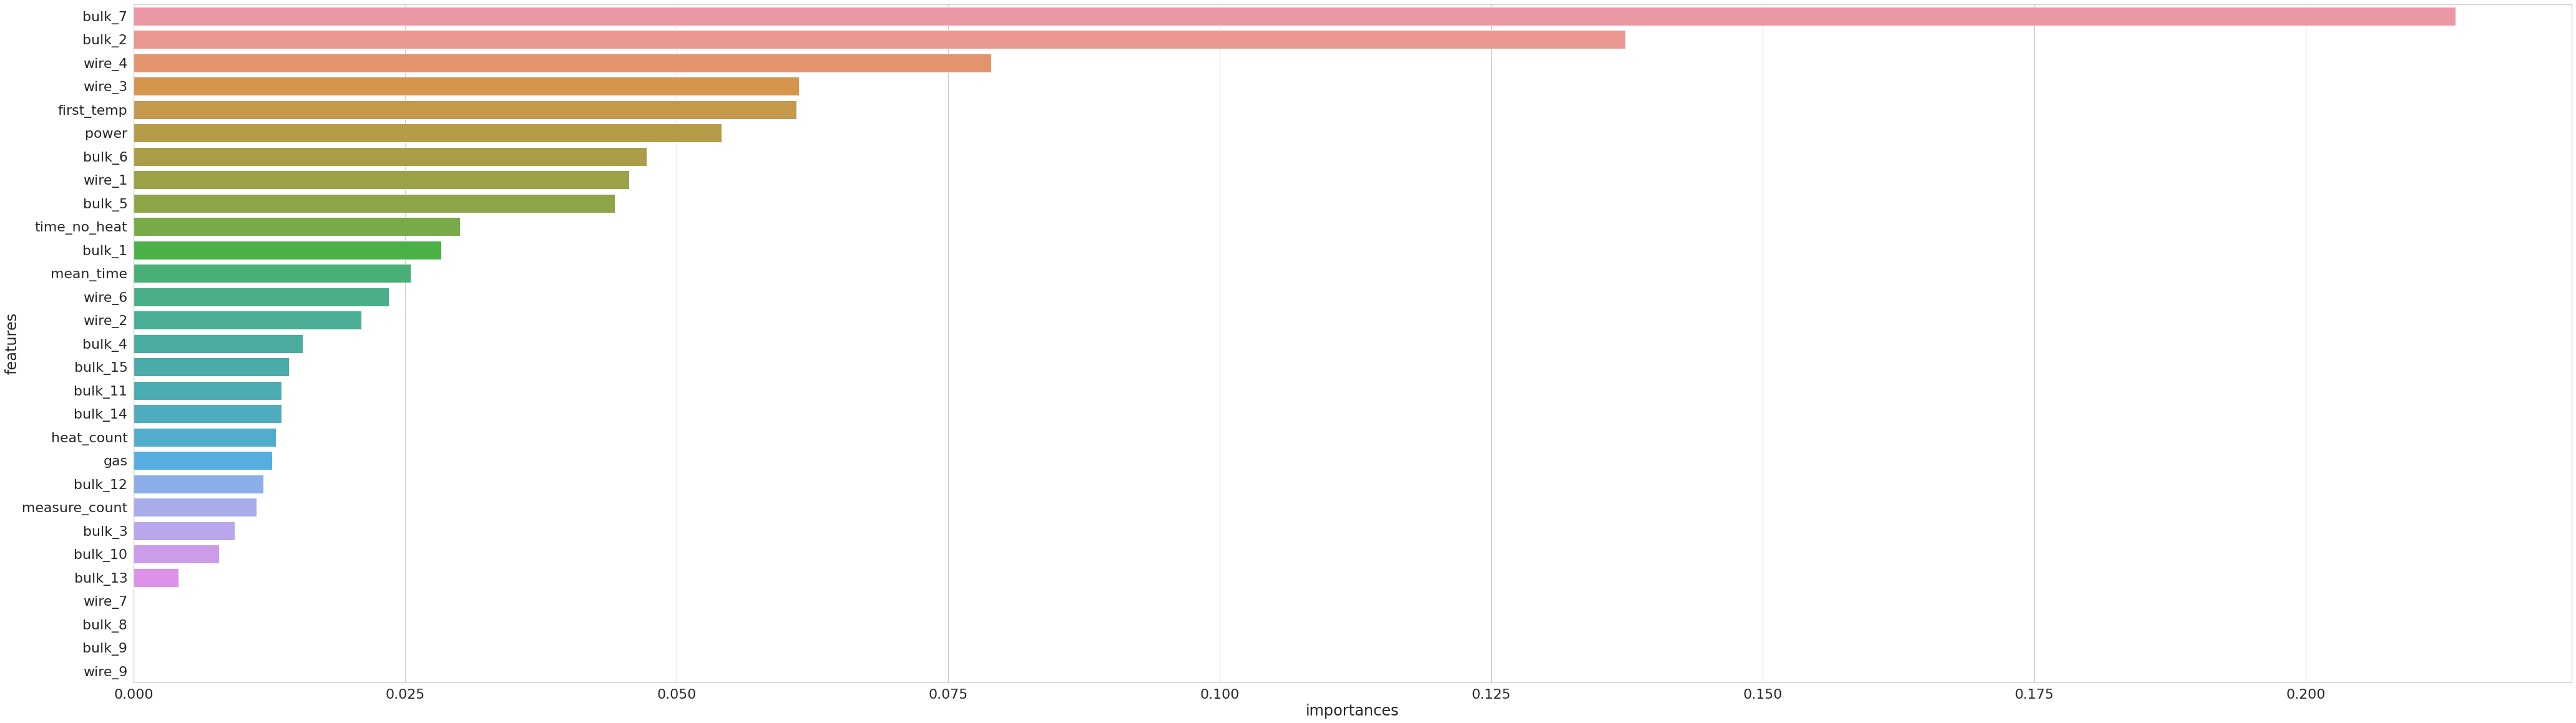

In [111]:
xgb = XGBRegressor(booster='gbtree', tree_method='hist', min_split_loss=11, max_depth=9, 
                   learning_rate=0.01, min_child_weight=5, n_estimators=1000)
xgb.fit(features, target)
importance = xgb.feature_importances_
importances = pd.DataFrame({'features': features.columns, 'importances': importance})
importances = importances.sort_values('importances', ascending=False)
sns.barplot(x='importances', y='features', data=importances)

### CatBoost

In [112]:
ctb = CatBoostRegressor(loss_function='RMSE', iterations=1000, random_state=12345, grow_policy='Lossguide')
get_scores(ctb, features, target, show=False)

Learning rate set to 0.045591
0:	learn: 15.0962419	total: 54.6ms	remaining: 54.6s
1:	learn: 14.7450007	total: 64.6ms	remaining: 32.2s
2:	learn: 14.4169019	total: 74.5ms	remaining: 24.8s
3:	learn: 14.1006978	total: 82.4ms	remaining: 20.5s
4:	learn: 13.8078071	total: 90.8ms	remaining: 18.1s
5:	learn: 13.5187060	total: 100ms	remaining: 16.6s
6:	learn: 13.2293875	total: 108ms	remaining: 15.4s
7:	learn: 12.9857967	total: 117ms	remaining: 14.6s
8:	learn: 12.7177604	total: 126ms	remaining: 13.9s
9:	learn: 12.4535657	total: 134ms	remaining: 13.3s
10:	learn: 12.2103991	total: 144ms	remaining: 13s
11:	learn: 11.9934842	total: 153ms	remaining: 12.6s
12:	learn: 11.8021340	total: 161ms	remaining: 12.3s
13:	learn: 11.5895505	total: 169ms	remaining: 11.9s
14:	learn: 11.4011243	total: 177ms	remaining: 11.6s
15:	learn: 11.2201510	total: 186ms	remaining: 11.4s
16:	learn: 11.0594133	total: 193ms	remaining: 11.2s
17:	learn: 10.9063076	total: 201ms	remaining: 10.9s
18:	learn: 10.7483049	total: 209ms	remain

5.80276310151481

Learning rate set to 0.047228
0:	learn: 15.6271469	total: 9.99ms	remaining: 9.98s
1:	learn: 15.2329402	total: 18.6ms	remaining: 9.28s
2:	learn: 14.8436259	total: 27.9ms	remaining: 9.27s
3:	learn: 14.4803427	total: 36.6ms	remaining: 9.11s
4:	learn: 14.1538489	total: 44.8ms	remaining: 8.92s
5:	learn: 13.8343402	total: 54.7ms	remaining: 9.07s
6:	learn: 13.5212406	total: 63.8ms	remaining: 9.05s
7:	learn: 13.2350851	total: 73.2ms	remaining: 9.08s
8:	learn: 12.9606421	total: 82.7ms	remaining: 9.11s
9:	learn: 12.6943736	total: 92.4ms	remaining: 9.15s
10:	learn: 12.4486497	total: 101ms	remaining: 9.12s
11:	learn: 12.2160794	total: 109ms	remaining: 8.99s
12:	learn: 11.9886165	total: 118ms	remaining: 8.95s
13:	learn: 11.7650062	total: 127ms	remaining: 8.91s
14:	learn: 11.5546446	total: 136ms	remaining: 8.95s
15:	learn: 11.3727131	total: 145ms	remaining: 8.94s
16:	learn: 11.1866057	total: 153ms	remaining: 8.87s
17:	learn: 11.0107417	total: 163ms	remaining: 8.89s
18:	learn: 10.8516599	total: 173ms

<AxesSubplot:xlabel='importances', ylabel='features'>

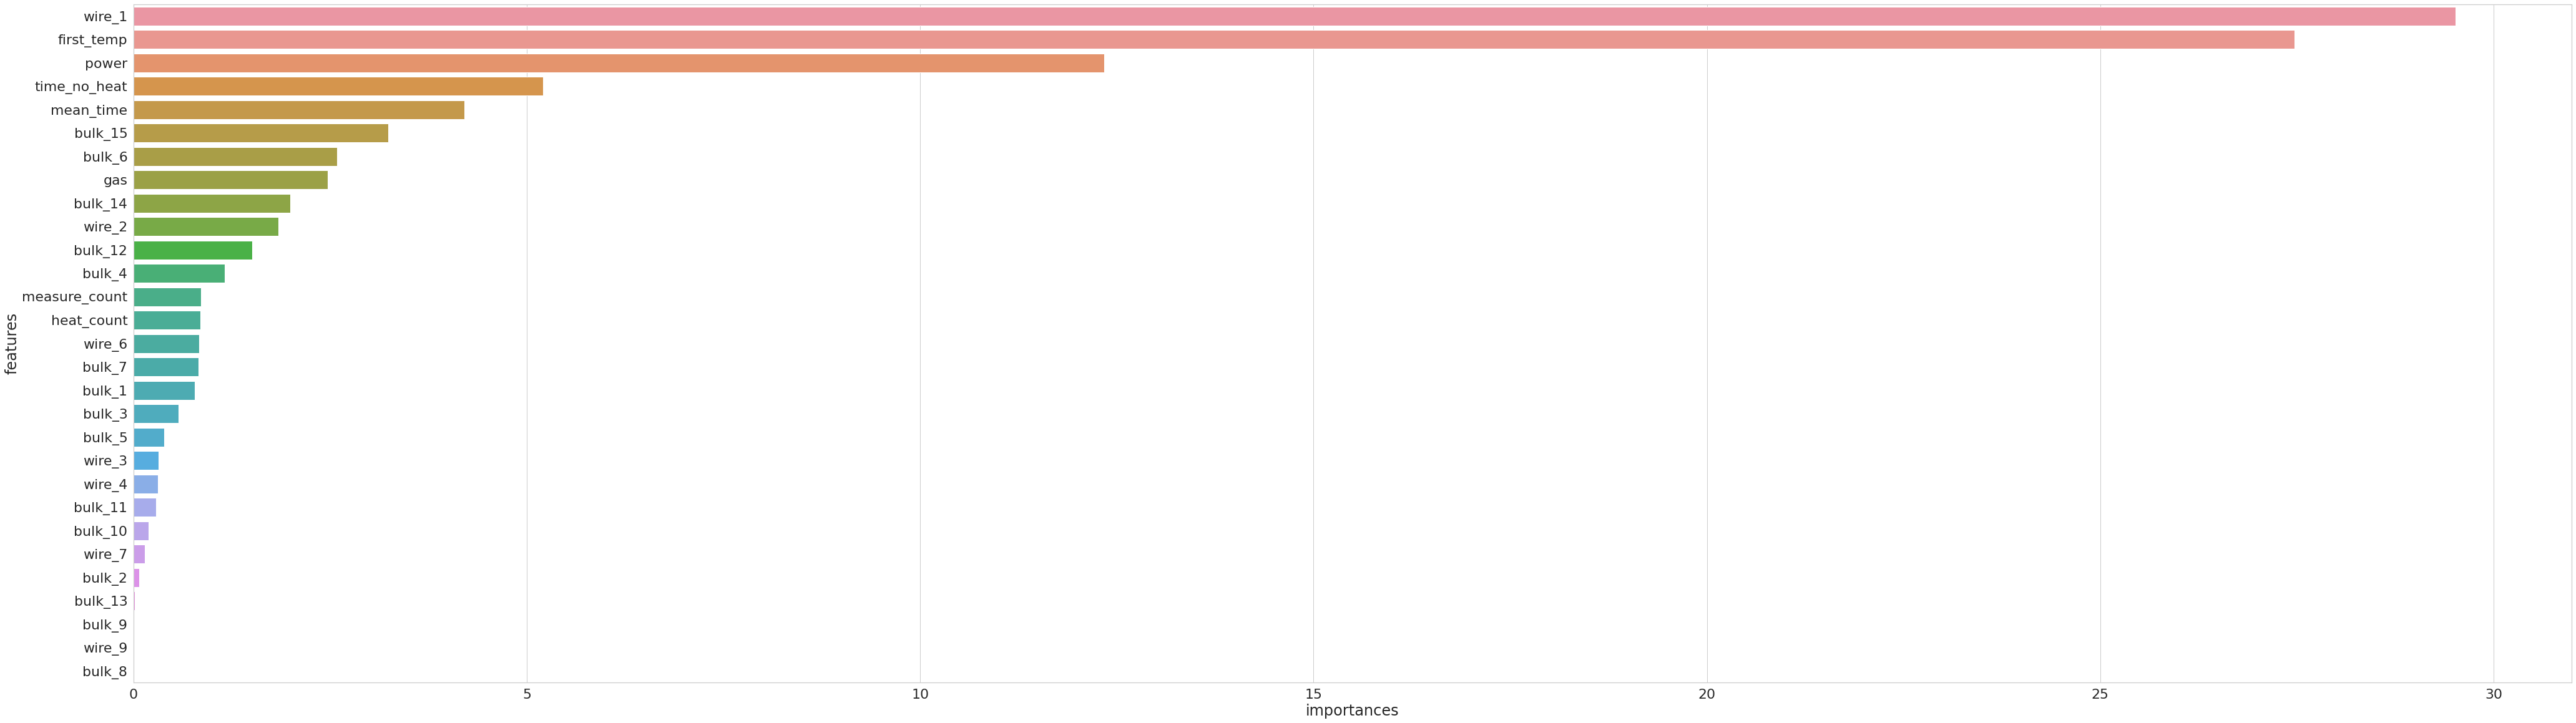

In [115]:
ctb = CatBoostRegressor(loss_function='RMSE', iterations=1000, random_state=12345, grow_policy='Lossguide')
ctb.fit(features, target)
importance = ctb.feature_importances_
importances = pd.DataFrame({'features': features.columns, 'importances': importance})
importances = importances.sort_values('importances', ascending=False)
sns.barplot(x='importances', y='features', data=importances)

## Отчет

Была поставлена задача построить модель, которая предсказывает конечную температуру сплава, для сокращения энергозатрат.  
Из всех предоставленных данных были использованы: данные об электродах; данные о подаче сыпучих материалов; проволочные материалы; подача газа; температура.  
    Была произведена следующая работа с имеющимися данными:  
 - изучение таблицы;  
 - приведение названий признаков к стандартному виду;  
 - обработаны некоторые выбросы;  
 - удалены незаписавшиеся партии;  
 - созданы новые признаки на основе старых.  
  
Итоговая таблица составлена на основе следующих признаков:  
 - стартовый(первый) замер температуры;  
 - количество замеров температуры в партии;  
 - количество нагревово в партии;  
 - среднее время нагрева;  
 - расходуемая мощность;  
 - время между нагревами;  
 - подаваемый газ(объем);  
 - суммарное количество сыпучих и проволочных добавок в партии;  
 - целевым признаком сделали последний замер температуры в партии.  

Опробована линейная регрессия, средний MAE 6.9 на 5-fold кросс-валидации.  

На следующих двух моделях гиперпараметры подбирались с помощью рандомизированного поиска по сетке и визуального подбора лучших комбинаций. Самыми важными признаками в случайном лесе стал признак с информацией по добавлению проволочных материалов(по индексу 1), признак начальная температура, на порядок менее важные мощность и время между нагревами. Среднее MAE на кросс-валидации 6.2.  

Далее с помощью тех же методов исследовали модель градиентного бустинга XGBoost. Лучшие 4 признака это сыпучие добавки(индексы 2 и 7), проволочные добавки(индексы 4 и 3).  

Модель CatBoost "из коробки" показала сопоставимый с XGBoost результат, но обучилась намного быстрее.  

В результате ансамблевые модели градиентного бустинга на решающих деревьях дают среднюю ошибку 5.8 градусов. Но это конечно не финальный результат, далее можно с помощью исследовательского анализа взглянуть на распределения нашей ошибки и уже с заказчиком начать обсуждение насколько данные погрешности приемлимы, возможно даже за счет увеличения MAE нужно уменьшить диапазон разброса, либо в процессе легирования более неприемлимы "перегревы" или "недогревы".  

Задача проекта выполнена, но для реального внедрения модели необходима дополнительная проработка всех этапов с заказчиком. На данном этапе были изучены признаки, прикинут вариант составления новых, опробованы на данных некоторые модели, сделан вывод о возможности использования машинного обучения для экономии электроэнергии в процессе легирования стали.